In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("/content/data.txt")

<ipython-input-3-e1490ae2eb2d>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [ ]:
# Features for correlation analysis
features = [
    "epoch",
    "moteid",
    "humidity",
    "light",
    "voltage"
]

# Ensure that 'temperature' is in the DataFrame
if 'temperature' in df.columns:
    print("Correlation with Temperature:\n")
    print(df[features].corrwith(df['temperature']))
else:
    print("Temperature column not found in the DataFrame.")


Temperature column not found in the DataFrame.


In [ ]:
df.head()

,2004-03-31 03:38:15.757551 2 1 122.153 -3.91901 11.04 2.03397
0,2004-02-28 00:59:16.02785 3 1 19.9884 37.0933 ...
1,2004-02-28 01:03:16.33393 11 1 19.3024 38.4629...
2,2004-02-28 01:06:16.013453 17 1 19.1652 38.803...
3,2004-02-28 01:06:46.778088 18 1 19.175 38.8379...
4,2004-02-28 01:08:45.992524 22 1 19.1456 38.940...


In [ ]:
import pandas as pd

# Define the column names
columns = ['date', 'time', 'epoch', 'moteid', 'temperature', 'humidity', 'light', 'voltage']

# Read the file
# Replace 'your_file_path.txt' with the path to your text file
# Adjust the 'sep' parameter if your data uses a different delimiter
df = pd.read_csv('/content/data.txt', sep="\s+", names=columns)

# Continue with your analysis...


We'll rely on PCA to untangle the correlational structure of these features and suggest relationships that might be usefully modeled with new features. Run this cell to apply PCA and extract the loadings.

In [ ]:
# Assuming these are the features you want to include based on your dataset
features = ['epoch', 'moteid', 'humidity', 'light', 'voltage']

X = df.copy()
y = X.pop("temperature")
X = X.loc[:, features]

# `apply_pca`, defined earlier in your script
# Drop rows with NaN values
X_dropped = X.dropna()

# Now apply PCA
pca, X_pca, loadings = apply_pca(X_dropped)
print(loadings)


               PC1       PC2       PC3       PC4       PC5
epoch     0.575024  0.020848 -0.544110 -0.213730  0.571993
moteid   -0.109900  0.689017 -0.265870  0.660463  0.079246
humidity -0.470193 -0.137484 -0.776456 -0.206797 -0.338182
light    -0.063949  0.708070  0.134535 -0.684452 -0.089294
voltage  -0.657342 -0.067501  0.110785 -0.082879  0.737701


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

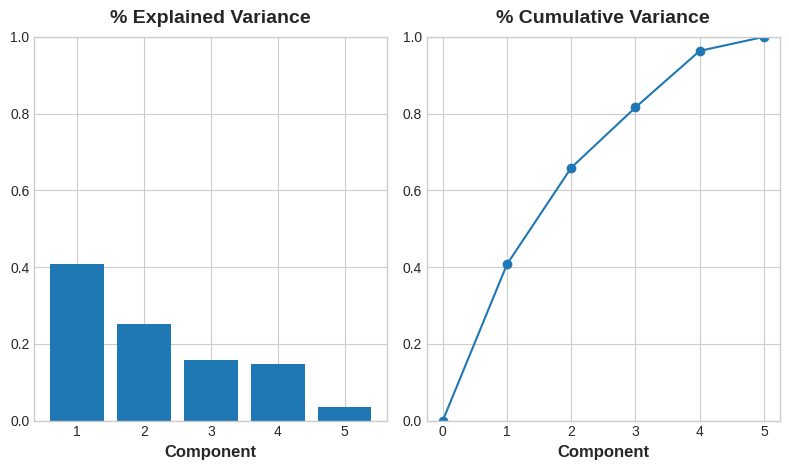

In [ ]:
plot_variance(pca)

Let's go on with 2nd option. We'll use now principal components as features.

-------------------------------------------------------------------------------

The next question explores a way you can use PCA to detect outliers in the dataset (meaning, data points that are unusually extreme in some way). Outliers can have a detrimental effect on model performance, so it's good to be aware of them in case you need to take corrective action. PCA in particular can show you anomalous *variation* which might not be apparent from the original features: neither small houses nor houses with large basements are unusual, but it is unusual for small houses to have large basements. That's the kind of thing a principal component can show you.

Run the next cell to show distribution plots for each of the principal components you created above.

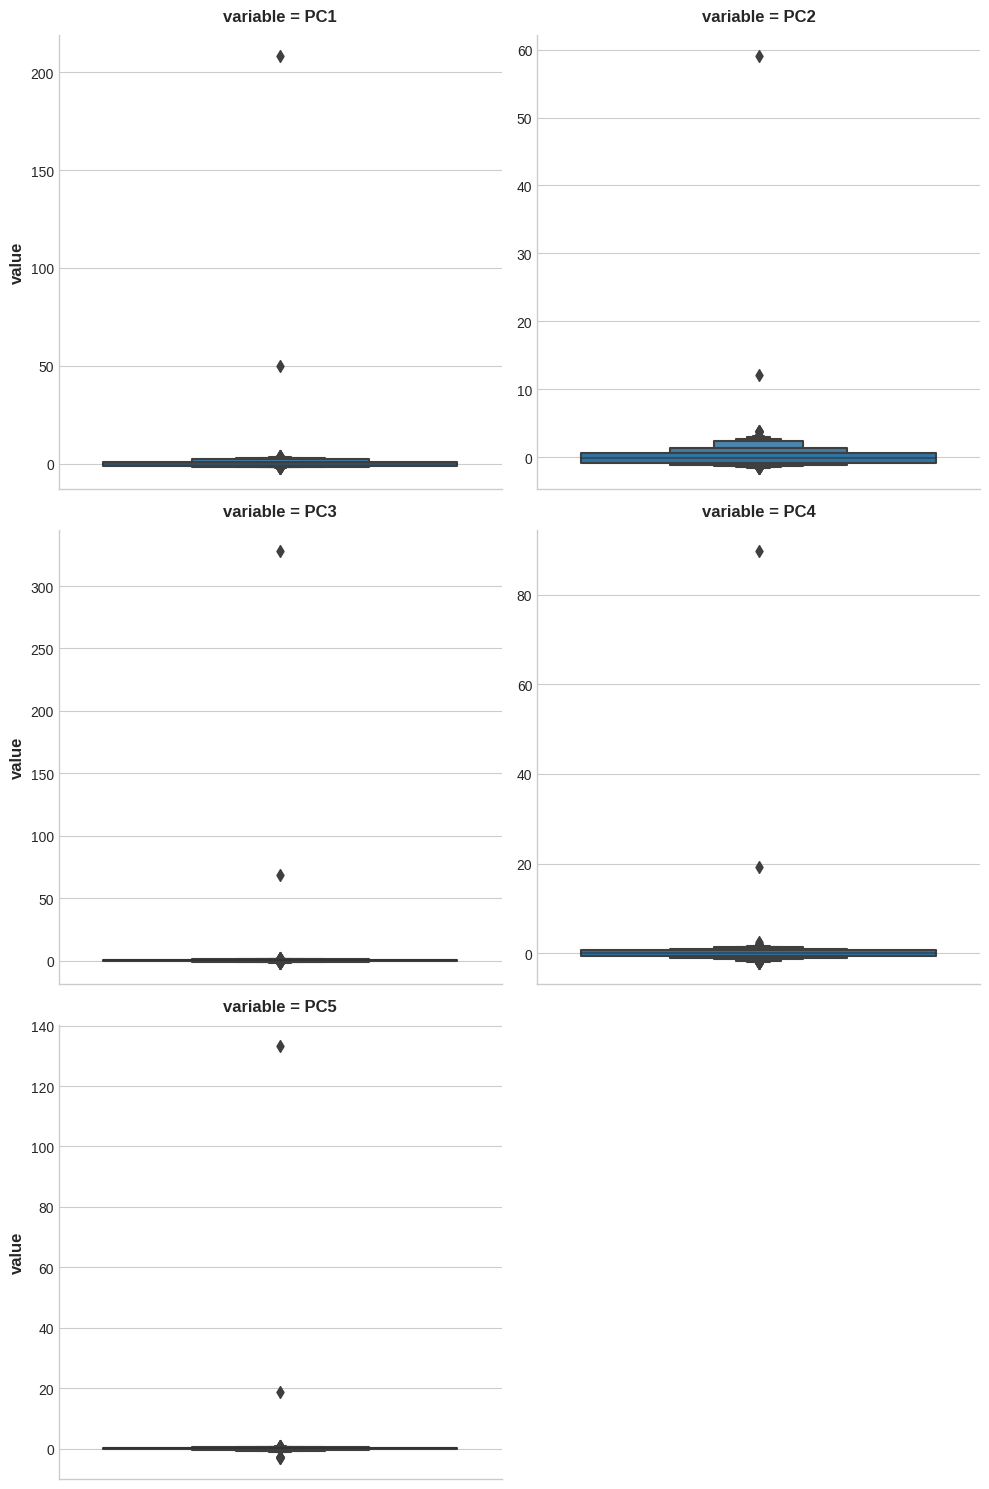

In [ ]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

As you can see, in each of the components there are several points lying at the extreme ends of the distributions -- outliers, that is.

Now run the next cell to see those houses that sit at the extremes of a component:

In [ ]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC1"

# Ensure the component exists in X_pca
if component in X_pca.columns:
    # Sort the index based on the component
    idx = X_pca[component].sort_values(ascending=False).index

    # Replace 'SalePrice', 'Neighborhood', 'SaleCondition' with relevant columns from your dataset
    relevant_columns = ['temperature', 'humidity', 'light']  # Adjust these columns as necessary
    df_subset = df.loc[idx, relevant_columns + features]
    print(df_subset)
else:
    print(f"{component} not found in X_pca")


        temperature    humidity    light    epoch  moteid    humidity  \
282665      24.7120    35.99120  1847.36  21665.0     8.0    35.99120   
43322        3.4068 -1854.52000   158.24    849.0     2.0 -1854.52000   
130968      20.9292    43.45240   323.84  55757.0     3.0    43.45240   
85101      122.0550    -3.91901    11.96  58905.0     2.0    -3.91901   
85102      122.0550    -3.91901    11.96  58906.0     2.0    -3.91901   
...             ...         ...      ...      ...     ...         ...   
288115      24.7512    28.04430  1023.04  32520.0     8.0    28.04430   
288097      24.5748    28.25900   890.56  32494.0     8.0    28.25900   
288098      24.6924    28.15170   890.56  32498.0     8.0    28.15170   
288092      24.5454    28.33050   861.12  32488.0     8.0    28.33050   
288040      22.3012    33.17590   397.44  32411.0     8.0    33.17590   

          light   voltage  
282665  1847.36  2.651430  
43322    158.24  0.018037  
130968   323.84  2.454210  
85101     1

### 3.1.3 | Outlier Detection

Do you notice any patterns in the extreme values? Does it seem like the outliers are coming from some special subset of the data? After you've thought about your answer, run the next cell for the solution and some discussion.

In addition, I'll include how I always try to detect outliers. As it's well known, an outlier can be of two types: Univariate and Multivariate. These outliers can be found when we look at distribution of a single variable. Multi-variate outliers are outliers in an n-dimensional space. We'll start by detecting whether there are univariate outliers in our dataset or not.

### 3.1.4 | Univariate Outliers

#### 3.1.4.1 | Grubbs Test

$$
\begin{array}{l}{\text { Grubbs' test is defined for the hypothesis: }} \\ {\begin{array}{ll}{\text { Ho: }}  {\text { There are no outliers in the data set }} \\ {\mathrm{H}_{\mathrm{1}} :}  {\text { There is exactly one outlier in the data set }}\end{array}}\end{array}
$$
$$
\begin{array}{l}{\text {The Grubbs' test statistic is defined as: }} \\ {\qquad G_{calculated}=\frac{\max \left|X_{i}-\overline{X}\right|}{SD}} \\ {\text { with } \overline{X} \text { and } SD \text { denoting the sample mean and standard deviation, respectively. }} \end{array}
$$
$$
G_{critical}=\frac{(N-1)}{\sqrt{N}} \sqrt{\frac{\left(t_{\alpha /(2 N), N-2}\right)^{2}}{N-2+\left(t_{\alpha /(2 N), N-2}\right)^{2}}}
$$
$$
\begin{array}{l}{\text { If the calculated value is greater than critical, you can reject the null hypothesis and conclude that one of the values is an outlier }}\end{array}$$

In [ ]:
import scipy.stats as stats
import numpy as np

def grubbs_test(x, feature):
    n = len(x)
    mean_x = np.mean(x)
    sd_x = np.std(x)
    numerator = max(abs(x - mean_x))
    g_calculated = numerator / sd_x
    print("Feature:", feature)
    print("Grubbs Calculated Value:", g_calculated)
    t_value = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)
    g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))
    print("Grubbs Critical Value:", g_critical)
    if g_calculated < g_critical:
        print("No outliers detected according to Grubbs' test.")
    else:
        print("Outliers detected according to Grubbs' test.")

    print("=" * 120)

# Check if the principal components exist and then apply Grubbs' test
for pc in ['PC1', 'PC2', 'PC3', 'PC4']:
    if pc in X_pca.columns:
        grubbs_test(X_pca[pc], pc)
    else:
        print(f"{pc} not found in X_pca")


Feature: PC1
Grubbs Calculated Value: 146.06074652873647
Grubbs Critical Value: 5.31090770932015
Outliers detected according to Grubbs' test.
Feature: PC2
Grubbs Calculated Value: 52.709880079176344
Grubbs Critical Value: 5.31090770932015
Outliers detected according to Grubbs' test.
Feature: PC3
Grubbs Calculated Value: 370.66929576793495
Grubbs Critical Value: 5.31090770932015
Outliers detected according to Grubbs' test.
Feature: PC4
Grubbs Calculated Value: 104.67621575687907
Grubbs Critical Value: 5.31090770932015
Outliers detected according to Grubbs' test.


#### 3.1.4.2 | Z-score method

Using Z score method,we can find out how many standard deviations value away from the mean.

![minipic](https://i.pinimg.com/originals/cd/14/73/cd1473c4c82980c6596ea9f535a7f41c.jpg)

 Figure in the left shows area under normal curve and how much area that standard deviation covers.
* 68% of the data points lie between + or - 1 standard deviation.
* 95% of the data points lie between + or - 2 standard deviation
* 99.7% of the data points lie between + or - 3 standard deviation

$\begin{array}{l} {R.Z.score=\frac{0.6745*( X_{i} - Median)}{MAD}}  \end{array}$

If the z score of a data point is more than 3 (because it cover 99.7% of area), it indicates that the data value is quite different from the other values. It is taken as outliers.

In [ ]:
import numpy as np

def Zscore_outlier(df):
    mean = np.mean(df)
    std = np.std(df)
    z_scores = np.abs((df - mean) / std)  # Calculate the absolute Z-scores
    outliers = np.where(z_scores > 3)  # Identify indices where Z-score is greater than 3
    return outliers[0]  # Return the indices of outliers

# Apply the function to PC1 of X_pca
outlier_indices = Zscore_outlier(X_pca['PC1'])
print("Outlier indices in PC1:", outlier_indices)


Outlier indices in PC1: [ 43322 282665]


In [ ]:
import numpy as np

def Zscore_outlier(df):
    mean = np.mean(df)
    std = np.std(df)
    z_scores = np.abs((df - mean) / std)  # Calculate the absolute Z-scores
    outliers = np.where(z_scores > 3)  # Identify indices where Z-score is greater than 3
    return outliers[0]  # Return the indices of outliers

# Apply the function to PC1 of X_pca
outlier_indices = Zscore_outlier(X_pca['PC2'])
print("Outlier indices in PC2:", outlier_indices)

Outlier indices in PC2: [ 43322 282665 406214 ... 456257 456265 457194]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


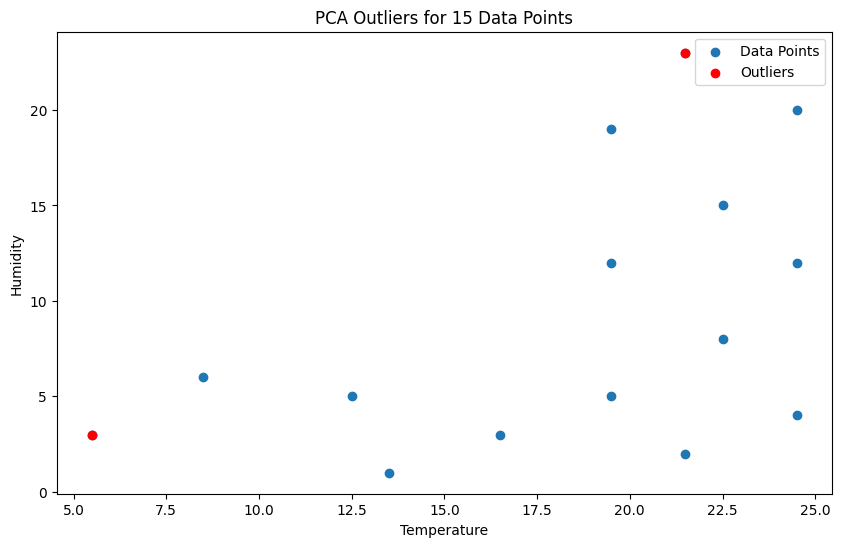

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


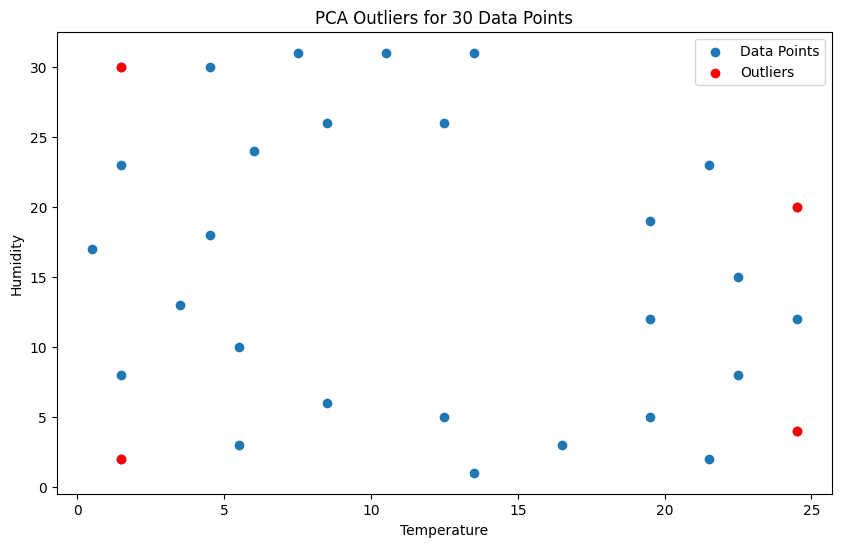

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


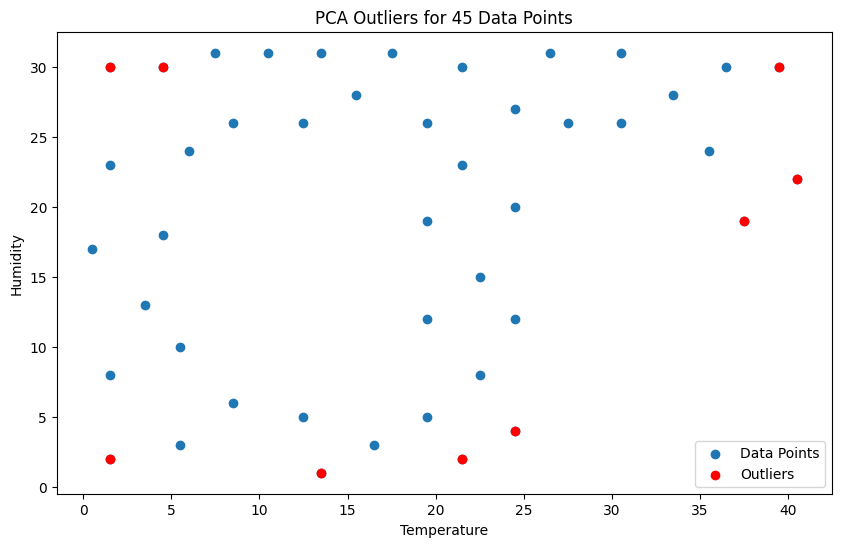

({'Subset Size': 15,
  'Outliers index': [0, 14],
  'Silhouette score': 0.45755285455366707,
  'Davis_Bouldin Index': 0.728965874263386},
 {'Subset Size': 30,
  'Outliers index': [1, 7, 15, 23],
  'Silhouette score': 0.42407913409821185,
  'Davis_Bouldin Index': 0.90647445250346},
 {'Subset Size': 45,
  'Outliers index': [7, 8, 11, 15, 23, 24, 41, 43, 44],
  'Silhouette score': 0.3777254359506918,
  'Davis_Bouldin Index': 1.0423149414566129})

In [ ]:
# Complete code combining the data, PCA transformation, Mahalanobis distance calculation, and plotting

import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Data provided by the user
data = np.array([
    [21.5, 23],
    [24.5, 20],
    [19.5, 19],
    [22.5, 15],
    [24.5, 12],
    [19.5, 12],
    [22.5, 8],
    [24.5, 4],
    [21.5, 2],
    [19.5, 5],
    [16.5, 3],
    [13.5, 1],
    [12.5, 5],
    [8.5, 6],
    [5.5, 3],
    [1.5, 2],
    [1.5, 8],
    [5.5, 10],
    [3.5, 13],
    [0.5, 17],
    [4.5, 18],
    [1.5, 23],
    [6, 24],
    [1.5, 30],
    [4.5, 30],
    [7.5, 31],
    [8.5, 26],
    [10.5, 31],
    [12.5, 26],
    [13.5, 31],
    [15.5, 28],
    [17.5, 31],
    [19.5, 26],
    [21.5, 30],
    [24.5, 27],
    [26.5, 31],
    [27.5, 26],
    [30.5, 31],
    [30.5, 26],
    [33.5, 28],
    [36.5, 30],
    [39.5, 30],
    [35.5, 24],
    [40.5, 22],
    [37.5, 19],
    [34.5, 16],
    [39.5, 14],
    [35.5, 10],
    [39.5, 6],
    [38.5, 1],
    [35.5, 4],
    [31.5, 6],
    [28.5, 5],
    [26.5, 2]
])

# Modified function to perform PCA, outlier detection, calculate scores and return all results

def pca_outlier_detection_and_scores(data_subset):
    # Perform PCA
    pca = PCA(n_components=2)
    pca_data_subset = pca.fit_transform(data_subset)

    # Calculate the inverse of covariance matrix for Mahalanobis distance
    mean_vector_subset = np.mean(pca_data_subset, axis=0)
    cov_matrix_subset = np.cov(pca_data_subset, rowvar=False)
    inv_cov_matrix_subset = np.linalg.inv(cov_matrix_subset)

    # Calculate the Mahalanobis distance for each point in the subset
    mahalanobis_distances_subset = np.array(
        [mahalanobis(point, mean_vector_subset, inv_cov_matrix_subset) for point in pca_data_subset])

    # Set a threshold for outlier detection using Mahalanobis distance
    threshold_subset = np.mean(mahalanobis_distances_subset) + np.std(mahalanobis_distances_subset)

    # Identify points that are considered outliers in the subset
    outliers_subset = np.where(mahalanobis_distances_subset > threshold_subset)[0]

    # Using KMeans for clustering to calculate silhouette score and Davies-Bouldin index
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=2)  # Assuming 2 clusters for demonstration
    labels = kmeans.fit_predict(pca_data_subset)

    # Calculate silhouette score and Davies-Bouldin index
    silhouette_avg = silhouette_score(pca_data_subset, labels)
    db_index = davies_bouldin_score(pca_data_subset, labels)

    # Plotting the subset data and highlighting the outliers
    plt.figure(figsize=(10, 6))
    plt.scatter(data_subset[:, 0], data_subset[:, 1], label='Data Points')
    plt.scatter(data_subset[outliers_subset, 0], data_subset[outliers_subset, 1], color='red', label='Outliers')
    plt.xlabel('Temperature')
    plt.ylabel('Humidity')
    plt.title(f'PCA Outliers for {len(data_subset)} Data Points')
    plt.legend()
    plt.show()

    # Returning all results
    return {
        'Subset Size': len(data_subset),
        'Outliers index': outliers_subset.tolist(),
        'Silhouette score': silhouette_avg,
        'Davis_Bouldin Index': db_index
    }

# Perform PCA and outlier detection on different subsets and calculate scores
results_15 = pca_outlier_detection_and_scores(data[:15, :])
results_30 = pca_outlier_detection_and_scores(data[:30, :])
results_45 = pca_outlier_detection_and_scores(data[:45, :])

# Displaying results for each subset
results_15, results_30, results_45



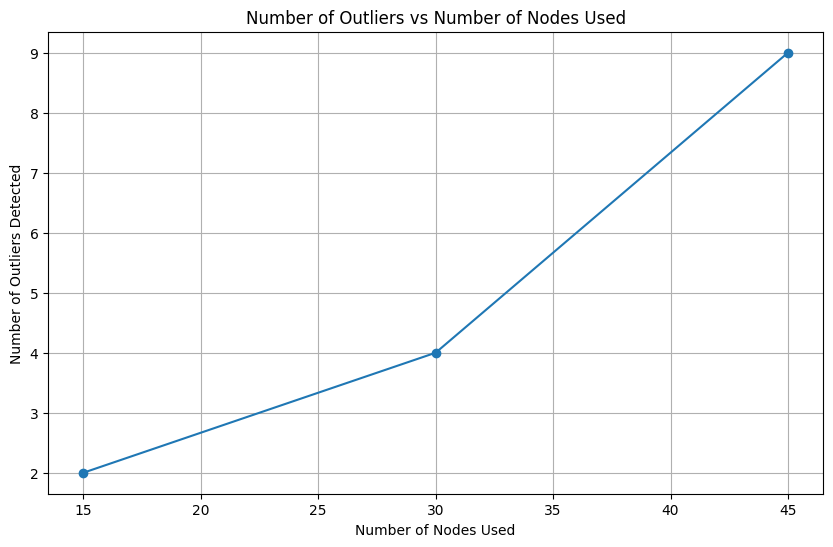

In [ ]:
# Modified Python code to generate the graph of number of outliers vs number of nodes used

# Number of outliers detected in each subset
num_outliers_detected = [
    len(results_15['Outliers index']),
    len(results_30['Outliers index']),
    len(results_45['Outliers index'])
]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(nodes_used, num_outliers_detected, marker='o')
plt.xlabel('Number of Nodes Used')
plt.ylabel('Number of Outliers Detected')
plt.title('Number of Outliers vs Number of Nodes Used')
plt.grid(True)
plt.show()
